# Imports

In [1]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "team_select_poc"
os.environ['LANGCHAIN_API_KEY'] = "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"

In [2]:
from typing import Any, TypedDict, Dict, Annotated
from pydantic import BaseModel
from operator import add
from IPython.display import Image, display, Markdown
from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import AgentAction
from langchain_openai import ChatOpenAI

import langgraph
from langgraph.graph import StateGraph, END
from chains import get_finish_chain, get_supervisor_chain
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage 


In [3]:
from tools import news_sentiment_tools
from prompts import get_news_sentiment_agent_prompt
from datetime import datetime
from llms import llm

# ALL IMPORTS
# from tools import financial_metrics_tools, news_sentiment_tools, market_intelligence_tools
# from prompts import get_financial_metrics_agent_prompt, get_news_sentiment_agent_prompt, get_market_intelligence_agent_prompt
# from sql_agent import query_database
# from datetime import datetime
# from llms import llm

# LLM 

In [4]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x13ed99250>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x13ed9aea0>, root_client=<openai.OpenAI object at 0x13ed04a10>, root_async_client=<openai.AsyncOpenAI object at 0x13ed992b0>, model_name='gpt-4o-mini', temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'))

# Config

In [5]:
settings = {
                "model": "gpt-4o-mini",
                "temperature": 0.3,
            }

# Callbacks

In [6]:
class CustomConsoleCallbackHandler(BaseCallbackHandler):
    def __init__(self):
        """Initialize the handler"""
        self.current_agent_name = None
        super().__init__()

    def write_agent_name(self, name: str):
        """Display agent name"""
        self.current_agent_name = name
        print(f"\n=== Agent: {name} ===")

    def on_tool_start(self, serialized: Dict[str, Any], input_str: str, **kwargs):
        """Display tool execution start"""
        print(f"\n🔧 Using tool: {serialized['name']}")

    def on_tool_end(self, output: str, **kwargs):
        """Display tool execution result"""
        print("\n📤 Tool output:")
        print("-" * 50)
        print(output)
        print("-" * 50)

    def on_agent_action(self, action: AgentAction, **kwargs):
        """Display agent action"""
        print(f"\n🎯 Action: {action.tool}")
        print("Input:")
        print("-" * 50)
        print(action.tool_input)
        print("-" * 50)

    def on_llm_start(self, serialized: Dict[str, Any], prompts: list[str], **kwargs):
        """Display when LLM starts processing"""
        print("\n🤔 Processing...")

    def on_llm_end(self, response, **kwargs):
        """Display final LLM response"""
        if hasattr(response, 'generations') and response.generations:
            print("\n Final LLM Response:")
            print("-" * 50)
            print(response.generations[0][0].text)
            print("-" * 50)

    def on_tool_error(self, error: str, **kwargs):
        """Display tool errors"""
        print(f"\n❌ Error: {error}")

# States

In [7]:
from personality import AgentPersonality

# Personality - default
sample_personality = AgentPersonality()
    
class TopicAdherenceEval(BaseModel):
    passed: Annotated[list[Any] , add] # will hold values of True or False
    reason: Annotated[list[Any] , add] # will hold reasons for the True or False

# Add state for all_tools_called_eval
class AllToolsEval(BaseModel):
    passed: Annotated[list[Any], add]  # bool value for if evalution passed = all tools were called successfully
    stats: Annotated[list[Any] , add]  # stats for each tool call, errors etc..
    

# Pydantic structure for model to evaluate response:
class LLM_TopicAdherenceEval(BaseModel):
    passed: str
    reason: str


class SentimentNewsState(BaseModel):
    agent_executor_tools: dict 
    full_response: dict
    all_tools_eval: AllToolsEval                    # Annotated[list[Any], add]
    topic_adherence_eval: TopicAdherenceEval        # Annotated[list[TopicAdherenceEval] , add]

# OVERALL AGENT STATE
class AgentState(TypedDict):
    current_date: datetime
    count: int
    user_input: str
    messages: list[BaseMessage , add]
    next_step: str
    config: dict
    callback: Any
    personality: AgentPersonality
    news_sentiment_agent_internal_state: SentimentNewsState
    # we can have internal states for all agents

# sample state:
# state = {   
#     "current_date": datetime.now(),
#     "messages": list(message_history.messages) + [prompt],
#     "user_input": prompt,
#     "config": settings,
#     "callback": callback_handler,
#     "personality": sample_personality
# }





# Helper functions

In [8]:
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str, max_iterations: int = 2,  return_intermediate_steps: bool = True) -> AgentExecutor:
    """
    Creates an agent using the specified ChatOpenAI model, tools, and system prompt.

    Args:
        llm : LLM to be used to create the agent.
        tools (list): The list of tools to be given to the worker node.
        system_prompt (str): The system prompt to be used in the agent.

    Returns:
        AgentExecutor: The executor for the created agent.
    """
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, max_iterations = max_iterations, return_intermediate_steps = return_intermediate_steps, verbose = True)
    return executor

In [9]:
def get_tools_call_eval_stats(result: Dict):
    """Helper function to format the output and store evaluation stats"""
    print("\n📊 TOOL EVALUATION SUMMARY")
    print("=" * 50)
    
    # Create stats dictionary to store in state
    run_stats = {
        "timestamp": datetime.now(),
        "all_tools_used": result["all_tools_used"],
        "tool_counts": result['tool_usage']['call_counts'],
        "errors": {
            "invalid_tools": result['tool_usage']['errors']['invalid_tools'],
            "execution_errors": result['tool_usage']['errors']['execution_errors'],
            "parser_errors": result['tool_usage']['errors']['parser_errors']
        }
    }
    
    # Print evaluation results
    all_tools_status = "✅" if result["all_tools_used"] else "❌"
    print(f"\n🎯 Overall Status:")
    print(f"  • All Required Tools Used: {all_tools_status}")
    
    print(f"\n📋 Tool Inventory:")
    print(f"  • Available Tools: {', '.join(result['tool_usage']['available_tools'])}")
    print(f"  • Successfully Used: {', '.join(result['tool_usage']['used_tools'])}")
    print(f"  • Not Used: {', '.join(result['tool_usage']['unused_tools'])}")
    
    print("\n📈 Usage Statistics:")
    for tool, count in result['tool_usage']['call_counts'].items():
        status = "✅" if count > 0 else "❌"
        print(f"  {status} {tool}: {count} calls")
    
    # Error Summary
    has_errors = any(len(errs) > 0 for errs in result['tool_usage']['errors'].values())
    if has_errors:
        print("\n⚠️ Error Summary:")
        errors = result['tool_usage']['errors']
        
        if errors['invalid_tools']:
            print("\n  Invalid Tool Attempts:")
            for err in errors['invalid_tools']:
                print(f"  • Requested: {err['requested']}")
                print(f"    Available: {', '.join(err['available'])}")
        
        if errors['execution_errors']:
            print("\n  Tool Execution Errors:")
            for err in errors['execution_errors']:
                print(f"  • Tool: {err['tool']}")
                print(f"    Input: {err['input']}")
                print(f"    Error: {err['error']}")
        
        if errors['parser_errors']:
            print("\n  Parser Errors:")
            for err in errors['parser_errors']:
                print(f"  • Input: {err['input']}")
                print(f"    Error: {err['error']}")
    
    print("\n🔍 Detailed Tool Execution Log:")
    for step in result["tools_used"]:
        status_emoji = {
            "success": "✅",
            "parser_error": "🔍",
            "invalid_tool": "❌",
            "execution_error": "⚠️"
        }.get(step['status'], "❓")
        
        print(f"\n  {status_emoji} Tool: {step['tool']}")
        print(f"    Status: {step['status']}")
        print(f"    Input: {step['input']}")
        if step['status'] == "success":
            print(f"    Output: {str(step['output'])[:100]}...")  # Truncate long outputs
    
    print("\n" + "=" * 50)
    
    return run_stats

# PROMPTS

In [10]:
TOPIC_ADHERENCE_PROMPT = """You are a specialized evaluator assessing the relevance and comprehensiveness of responses from the News & Sentiment Agent.

The News & Sentiment Agent is designed to provide:
- Sentiment analysis of news and social media coverage
- Social media trends and engagement metrics
- Market perception tracking across news sources
- Analysis of public opinion and investor sentiment
- Identification of key narratives and themes

The user asked:
{question}

The News & Sentiment Agent responded with:
{answer}

Evaluate if the answer effectively addresses the user's question by providing relevant sentiment analysis, social trends, and market perception insights.

Your response must be valid JSON matching this exact format:
{{
    "passed": "true" or "false",
    "reason": "Brief explanation of your evaluation"
}}

Guidelines for evaluation:
- "passed" should be "true" if the answer:
  * Directly addresses the main points of the question
  * Includes relevant sentiment analysis and market perception data
  * Provides social media trends and engagement insights when applicable
  * Synthesizes information from multiple sources to give a complete picture

- "passed" should be "false" if the answer:
  * Is off-topic or misses the core question
  * Lacks sentiment analysis or market perception insights
  * Fails to include relevant social trends and engagement data
  * Provides incomplete or superficial analysis

- The "reason" should specifically explain how well the response incorporated sentiment analysis, social trends, and market perception tracking in addressing the query
"""

# Nodes

In [11]:
news_sentiment_tools

[StructuredTool(name='company_news', description='Searches for a collection of news articles [most relevant, most socially shared and keyword based news] based on the given company name and industry keywords, and returns the news context as a list of articles.\n\nArgs:\n    company_name (str): The name of the company for finding relevant news articles.\n    industry_keywords (list): A list of keywords related to the industry.\n\nReturns:\n    list: A list of dictionaries containing the news articles.', args_schema=<class 'langchain_core.utils.pydantic.company_news'>, func=<function company_news at 0x16d30db20>),
 StructuredTool(name='industry_news', description='Fetches the most relevant articles related to a given list of industry keywords.\nArgs:\n    industry_keywords (list): A list of keywords representing the industry of interest.\nReturns:\n    list: A list of news articles related to the provided industry keywords.', args_schema=<class 'langchain_core.utils.pydantic.industry_new

In [12]:
# News sentiment node
def news_sentiment_node(state):
    """
    Handles news analysis and sentiment tracking using tools from tools.py
    """

    if "count" not in state:
        state["iteration_count"] = 0

    print("\n" + "-"*50)
    print("📰 NEWS SENTIMENT NODE, COUNT: ", state["count"])
    #print("STATE: ", state)

    
    sentiment_agent = create_agent(
        llm,
        news_sentiment_tools,
        get_news_sentiment_agent_prompt(state.get("current_date"), state.get("personality"), state.get("user_input"))
    )
    
    state["callback"].write_agent_name("News & Sentiment Agent 📰")
    output = sentiment_agent.invoke(
        {"messages": state["messages"]}, # state["messages"] # [HumanMessage(state["user_input"])]
        {"callbacks": [state["callback"]], } , return_intermediate_steps = True
    )
    print(f"Analysis complete - Output length: {len(output.get('output', ''))}")
    
    state["messages"].append(
        AIMessage(content=output.get("output"), name="NewsSentiment") # changed it from Human to AIMessage
    )

    # ADDED: sentiment_agent tools:
    available_tools = {tool.name: 0 for tool in sentiment_agent.tools}                                           
    state["news_sentiment_agent_internal_state"]["agent_executor_tools"] = available_tools
    state["news_sentiment_agent_internal_state"]["full_response"] = output # output contains all the messages
    #print("THIS IS THE OUTPUT: ", output)
    
    # Increment the count
    state["count"] += 1

    print("-"*50 + "\n")
    return state

# Evaluate all tools called:
def evaluate_all_tools_called(state):
    """Evaluates tool usage and stores statistics in state"""
    sample_response = state['news_sentiment_agent_internal_state']
    print("INSIDE EVALUATE ALL TOOLS CALLED: ", sample_response)
    
    # This dictionary will be used for later evaluation statistics
    result = {
        "answer": sample_response['full_response']["output"],
        "tools_used": [],
        "all_tools_used": False,
        "tool_usage": {
            "available_tools": list(sample_response['agent_executor_tools'].keys()),
            "used_tools": set(),
            "unused_tools": set(),
            "call_counts": sample_response['agent_executor_tools'].copy(),
            "errors": {
                "invalid_tools": [],
                "execution_errors": [],
                "parser_errors": []
            }
        }
    }

    # Process intermediate steps
    for action, observation in sample_response['full_response']["intermediate_steps"]:
        # print( 'ACTION: ', action)
        # print(' OBSERVATION: ', observation)
        tool_name = action.tool
        tool_input = action.tool_input
        
        # Determine status based on observation
        status = "success"  # Default, but will be immediately evaluated
        
        if tool_name == "_Exception":
            status = "parser_error"
            result["tool_usage"]["errors"]["parser_errors"].append({
                "input": tool_input,
                "error": observation
            })
        elif isinstance(observation, dict) and "requested_tool_name" in observation:
            status = "invalid_tool"
            result["tool_usage"]["errors"]["invalid_tools"].append({
                "requested": tool_name,
                "available": observation.get("available_tool_names", [])
            })
        elif isinstance(observation, dict) and next(iter(observation), "").lower().startswith("error"):
            
            status = "execution_error"
            result["tool_usage"]["errors"]["execution_errors"].append({
                "tool": tool_name,
                "input": tool_input,
                "error": observation
            })

        tool_result = {
            "tool": tool_name,
            "input": tool_input,
            "output": observation,
            "status": status
        }
        
        # Only count successful executions in usage statistics
        if status == "success":
            result["tool_usage"]["used_tools"].add(tool_name)
            result["tool_usage"]["call_counts"][tool_name] += 1

        result["tools_used"].append(tool_result)

    # Calculate unused tools
    
    # Set of tool names (strings) that were available but not used
    result["tool_usage"]["unused_tools"] = set(result["tool_usage"]["available_tools"]) - result["tool_usage"]["used_tools"]
    result["all_tools_used"] = len(result["tool_usage"]["unused_tools"]) == 0

    # Store evaluation stats in state
    run_stats = get_tools_call_eval_stats(result)
    
    # Initialize all_tools_eval if needed
    if 'stats' not in state['news_sentiment_agent_internal_state']['all_tools_eval']:
        state['news_sentiment_agent_internal_state']['all_tools_eval'] = {
            'stats': [],
            'passed': []
        }
    
    # Append new stats and pass/fail status
    state['news_sentiment_agent_internal_state']['all_tools_eval']['stats'].append(run_stats)
    state['news_sentiment_agent_internal_state']['all_tools_eval']['passed'].append(result["all_tools_used"])
    
    return state

# Evaluate topic adherene
def evaluate_topic_adherence(state):
    print(' INSIDE evaluate_topic_adherence')
    messages = [
        SystemMessage(content=TOPIC_ADHERENCE_PROMPT.format(
            question=state['user_input'],
            answer= state['news_sentiment_agent_internal_state']['full_response']['output']
        ))
    ]
    llm_evaluator = llm.with_structured_output(LLM_TopicAdherenceEval)
    response = llm_evaluator.invoke(messages)
    
    # Append to the internal state:
    state['news_sentiment_agent_internal_state']['topic_adherence_eval']['passed'].append(response.passed)
    state['news_sentiment_agent_internal_state']['topic_adherence_eval']['reason'].append(response.reason)
    return state

# Edges 

In [13]:
def execute_again_all_tools_called(state):
    print("INSIDE execute_again_all_tools_called")
    # all_tools_called_eval_passed will contain a booleean
    passed = state['news_sentiment_agent_internal_state']['all_tools_eval']['passed'][-1]
    iterations = len(state['news_sentiment_agent_internal_state']['all_tools_eval']['passed'])
    print("passed value:" ,passed )
    print('iterations: ', iterations, 'values: ' , state['news_sentiment_agent_internal_state']['all_tools_eval']['passed'])

    if passed or iterations >= 2:
   
        return "EvaluateTopicAdherence"
    else:
        print('GO BACK TO THE AGENT, tools not passed')
        return "NewsSentimentAgent"


# Conditional edge to decide wether to END of go back to NewsSentimentAgent
def execute_again_topic_adherence(state):
    print('INSIDE execute_again_topic_adherence')
    
    # Check if 'topic_adherence_eval' has any evaluations
    if not state['news_sentiment_agent_internal_state']['topic_adherence_eval']['passed']:
        print("No topic adherence evaluations found.")
        return "NewsSentimentAgent"  
    
    # Access the latest evaluation
    last_passed = state['news_sentiment_agent_internal_state']['topic_adherence_eval']['passed'][-1].lower()
    # Check how many evaluations occured
    iterations = len(state['news_sentiment_agent_internal_state']['topic_adherence_eval']['passed'])
    
    print("TOPIC ADHERENCE EVALUATION PASSED:", last_passed)
    print("NUMBER OF ITERATIONS FOR TOPIC ADHERENCE:", iterations)

    if last_passed == "true" or iterations >= 2: 
        print(f'ENDING! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "end"
    else:
        print(f'RETURN TO AGENT, adherence failed! iterations {iterations}, value of topic_adherence: {last_passed}')
        return "NewsSentimentAgent"


# Define and Build the Graph

In [14]:
def define_graph():
    """
    Defines and returns a graph representing the financial analysis workflow.
    """
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("NewsSentimentAgent", news_sentiment_node)
    workflow.add_node("EvaluateAllToolsCalled", evaluate_all_tools_called)
    workflow.add_node("EvaluateTopicAdherence", evaluate_topic_adherence)
    
    # Set entry point
    workflow.set_entry_point("NewsSentimentAgent")
    
    # Add edges
    workflow.add_edge("NewsSentimentAgent", "EvaluateAllToolsCalled")
    
    workflow.add_conditional_edges("EvaluateAllToolsCalled", execute_again_all_tools_called, 
    {
        "EvaluateTopicAdherence": "EvaluateTopicAdherence", #"EvaluateTopicAdherence",
        "NewsSentimentAgent": "NewsSentimentAgent"
    }
      )
    
    workflow.add_conditional_edges("EvaluateTopicAdherence", execute_again_topic_adherence,                           
    {
        "end": END, 
        "NewsSentimentAgent": "NewsSentimentAgent"
    }
      )
                            
    return workflow.compile()

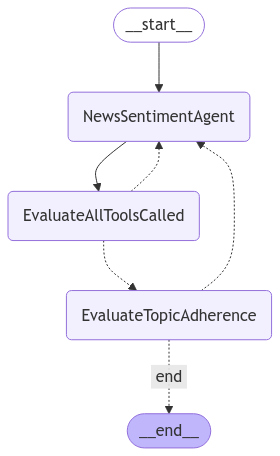

In [15]:
graph = define_graph()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

# Test the graph

In [16]:
def test_agent(agent: langgraph.graph.state.CompiledStateGraph, question: str, verbose: bool = True):
    """Run a test query through the agent"""
    callback_handler = CustomConsoleCallbackHandler()
    # callback.verbose = verbose
   
    initial_state = {
        "current_date": datetime.now(),
        "count": 0, 
        "user_input": question,
        "messages": [],
        "next_step": "",
        "config": settings,
        "callback": callback_handler,
        "personality": sample_personality,
        "news_sentiment_agent_internal_state": {
            "agent_executor_tools": {},
            "full_response": {},
            "all_tools_eval": {
                "stats": [],
                "passed": []
            },
            "topic_adherence_eval": {
                "passed": [],
                "reason": []
            }
        }
    }
    # Run the agent
    response = graph.invoke(initial_state)
    
    return response

In [17]:
response = test_agent(graph , "Tell me about the best quantum computing companies in the market", verbose = True)


--------------------------------------------------
📰 NEWS SENTIMENT NODE, COUNT:  0

=== Agent: News & Sentiment Agent 📰 ===


> Entering new AgentExecutor chain...

🤔 Processing...

 Final LLM Response:
--------------------------------------------------

--------------------------------------------------

🎯 Action: company_news
Input:
--------------------------------------------------
{'company_name': 'IBM'}
--------------------------------------------------

Invoking: `company_news` with `{'company_name': 'IBM'}`



🔧 Using tool: company_news

📤 Tool output:
--------------------------------------------------
[{'uri': '8386160217', 'lang': 'eng', 'isDuplicate': False, 'date': '2024-10-29', 'time': '12:17:46', 'dateTime': '2024-10-29T12:17:46Z', 'dateTimePub': '2024-10-29T12:17:24Z', 'dataType': 'news', 'sim': 0.9529411792755127, 'url': 'https://www.eagletribune.com/region/veracode-research-highlights-financial-sector-s-escalating-security-debt/article_d366e699-8131-5f45-8e79-a1641430

In [19]:
response = test_agent(graph , "Is Nvidia a profitable company?", verbose = True)


--------------------------------------------------
📰 NEWS SENTIMENT NODE, COUNT:  0

=== Agent: News & Sentiment Agent 📰 ===


> Entering new AgentExecutor chain...

🤔 Processing...

 Final LLM Response:
--------------------------------------------------

--------------------------------------------------

🎯 Action: company_news
Input:
--------------------------------------------------
{'company_name': 'Nvidia'}
--------------------------------------------------

Invoking: `company_news` with `{'company_name': 'Nvidia'}`



🔧 Using tool: company_news

📤 Tool output:
--------------------------------------------------
[{'uri': '8418423277', 'lang': 'eng', 'isDuplicate': False, 'date': '2024-11-19', 'time': '09:12:16', 'dateTime': '2024-11-19T09:12:16Z', 'dateTimePub': '2024-11-19T09:11:58Z', 'dataType': 'news', 'sim': 0.9882352948188782, 'url': 'https://npinvestor.dk/node/514826', 'title': 'Temenos powers on-premises generative AI for real-time banking with NVIDIA accelerated computing'

# EXAMPLE OF EVALUATION:

## Plotting Statistics of a single run

In [53]:
import seaborn as sns

In [21]:
all_tools_eval_results =response['news_sentiment_agent_internal_state']['all_tools_eval']
topic_adherence_eval_results =response['news_sentiment_agent_internal_state']['topic_adherence_eval']

In [22]:
all_tools_eval_results.keys()

dict_keys(['stats', 'passed'])

## **All tools called analysis**

In [23]:
response['news_sentiment_agent_internal_state']['agent_executor_tools']

{'company_news': 0,
 'industry_news': 0,
 'get_news_sentiment': 0,
 'polygon_ticker_news': 0}

In [24]:
# len of all_tools_eval_results['stats'] shows how many times we had to run the agent
# due to its output not passing the all_tools_eval evaluation
print(f"There was a total of {len(all_tools_eval_results['stats'])} iterations")

There was a total of 1 iterations


In [25]:
all_tools_eval_results['stats']

[{'timestamp': datetime.datetime(2024, 11, 23, 17, 56, 57, 74186),
  'all_tools_used': True,
  'tool_counts': {'company_news': 1,
   'industry_news': 1,
   'get_news_sentiment': 1,
   'polygon_ticker_news': 1},
  'errors': {'invalid_tools': [],
   'execution_errors': [],
   'parser_errors': []}}]

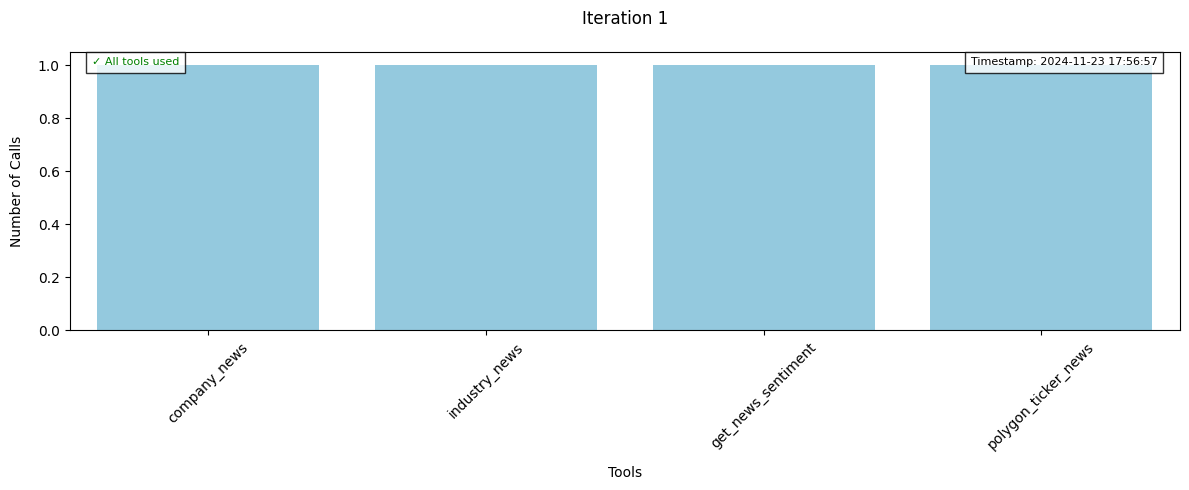

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import wrap

# Calculate number of iterations and set up the subplots
n_iterations = len(all_tools_eval_results['stats'])
fig, axes = plt.subplots(n_iterations, 1, figsize=(12, 5*n_iterations))
if n_iterations == 1:
    axes = [axes]  # Convert to list for consistent indexing

# Process each iteration
for iteration_idx, (ax, iteration_stats) in enumerate(zip(axes, all_tools_eval_results['stats'])):
    # Create DataFrame for this iteration
    tool_counts = iteration_stats['tool_counts']
    
    # Create a mapping of tools to their error messages
    error_messages = {}
    for error in iteration_stats['errors']['execution_errors']:
        tool = error['tool']
        error_msg = error['error'].get('error', str(error['error']))
        error_messages[tool] = error_msg
    
    # Create DataFrame for this iteration
    iteration_data = []
    for tool, count in tool_counts.items():
        has_error = tool in error_messages
        iteration_data.append({
            'Tool': tool,
            'Calls': count,
            'Has Error': has_error,
            'Error Message': error_messages.get(tool, 'No error')
        })
    
    df = pd.DataFrame(iteration_data)
    
    # Create bar plot for this iteration
    sns.barplot(
        data=df,
        x='Tool',
        y='Calls',
        ax=ax,
        color='skyblue'
    )
    
    # Add error markers and annotations
    for idx, row in df.iterrows():
        if row['Has Error']:
            # Plot red X
            ax.plot(
                idx,
                row['Calls'],
                'rx',
                markersize=10,
                markeredgewidth=2,
                label='Error'
            )
            
            # Add error message annotation
            ax.annotate(
                f"Error: {row['Error Message']}",
                xy=(idx, row['Calls']),
                xytext=(10, 10),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                fontsize=8,
                wrap=True
            )
        
        # Add annotation for zero calls
        if row['Calls'] == 0:
            ax.annotate(
                'Not Called',
                xy=(idx, 0),
                xytext=(0, -20),
                textcoords='offset points',
                ha='center',
                va='top',
                color='red',
                fontsize=8
            )
    
    # Customize subplot
    ax.set_title(f'Iteration {iteration_idx + 1}', pad=20, size=12)
    ax.set_xlabel('Tools', labelpad=10)
    ax.set_ylabel('Number of Calls', labelpad=10)
    ax.tick_params(axis='x', rotation=45)
    
    # Add timestamp
    timestamp = iteration_stats['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
    ax.text(0.98, 0.98, f'Timestamp: {timestamp}', 
            transform=ax.transAxes, 
            ha='right', 
            va='top', 
            fontsize=8, 
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Add all_tools_used status
    status_text = "✓ All tools used" if iteration_stats['all_tools_used'] else "✗ Not all tools used"
    ax.text(0.02, 0.98, status_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=8,
            color='green' if iteration_stats['all_tools_used'] else 'red',
            bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.show()

## **Topic Adherence Eval**

In [27]:
topic_adherence_eval_results =response['news_sentiment_agent_internal_state']['topic_adherence_eval']

In [28]:
topic_adherence_eval_results

{'passed': ['true'],
 'reason': ["The response effectively addresses the user's question about Nvidia's profitability by providing a comprehensive analysis of the company's recent performance, including strong earnings driven by AI demand. It includes sentiment analysis with a positive outlook, market perception insights, and mentions of strategic initiatives and industry context, which collectively support the conclusion that Nvidia is a profitable company."]}

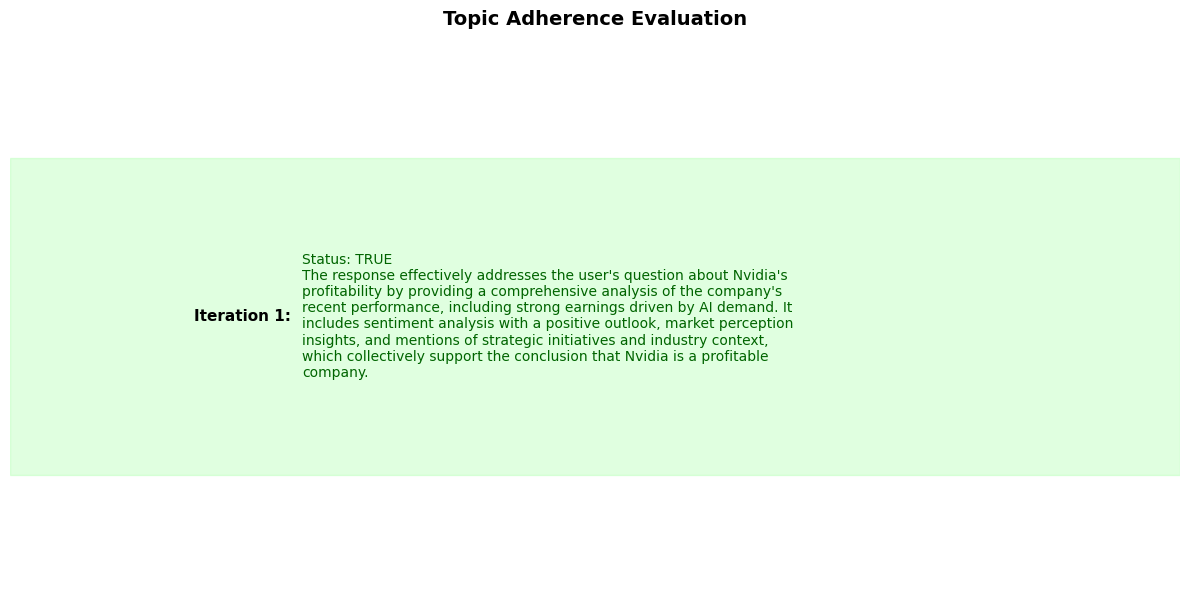

In [29]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create data for visualization
iterations = len(topic_adherence_eval_results['passed'])
y_positions = range(iterations)

# Add background colors for each iteration (adjusted height)
for i, status in enumerate(topic_adherence_eval_results['passed']):
    color = '#ff9999' if status.lower() == 'false' else '#99ff99'
    # Extend the background to fully include the iteration label
    ax.axhspan(i-0.3, i+0.3, color=color, alpha=0.3)

# Add iteration numbers and evaluation details
for i, (status, reason) in enumerate(zip(topic_adherence_eval_results['passed'], 
                                       topic_adherence_eval_results['reason'])):
    # Move iteration number inside the colored background
    ax.text(0.02, i, f'Iteration {i+1}:', 
            ha='left', va='center',
            fontsize=11, fontweight='bold')
    
    # Format the reason text (wrap at 70 characters)
    wrapped_reason = '\n'.join(wrap(reason, width=70))
    
    # Create display text with status and reason (moved right to accommodate iteration number)
    display_text = f"Status: {status.upper()}\n{wrapped_reason}"
    
    ax.text(0.15, i, display_text,
            ha='left', va='center',
            fontsize=10,
            color='darkred' if status.lower() == 'false' else 'darkgreen')

# Customize plot
ax.set_title('Topic Adherence Evaluation', pad=20, fontsize=14, fontweight='bold')
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.5, iterations-0.5)

# Remove axes and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a light grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## **SUMMARY OF THE RUN**

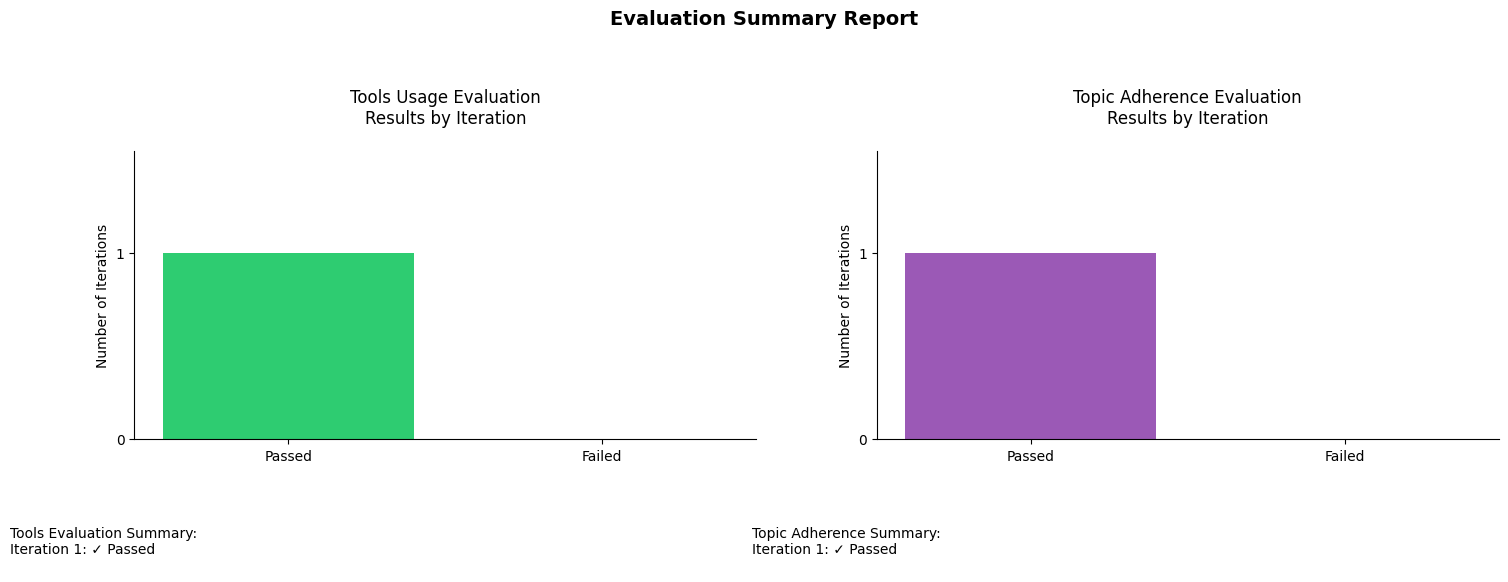

In [30]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Tools Evaluation Summary (Left Plot) ---
tools_results = all_tools_eval_results['passed']
tools_stats = {
    'Passed': sum(tools_results),
    'Failed': len(tools_results) - sum(tools_results)
}

# Create summary text for tools
tools_summary = "Tools Evaluation Summary:\n"
for i, passed in enumerate(tools_results):
    status = "✓ Passed" if passed else "✗ Failed"
    tools_summary += f"Iteration {i+1}: {status}\n"

# Plot tools results with blue palette
ax1.bar(['Passed', 'Failed'], 
        [tools_stats['Passed'], tools_stats['Failed']], 
        color=['#2ecc71', '#3498db'])  # Green and Blue
ax1.set_title('Tools Usage Evaluation\nResults by Iteration', pad=20)
ax1.text(-0.2, -0.3, tools_summary, 
         transform=ax1.transAxes, 
         verticalalignment='top',
         fontsize=10)

# --- Topic Adherence Summary (Right Plot) ---
topic_results = [status.lower() == 'true' for status in topic_adherence_eval_results['passed']]
topic_stats = {
    'Passed': sum(topic_results),
    'Failed': len(topic_results) - sum(topic_results)
}

# Create summary text for topic adherence
topic_summary = "Topic Adherence Summary:\n"
for i, status in enumerate(topic_adherence_eval_results['passed']):
    status_text = "✓ Passed" if status.lower() == 'true' else "✗ Failed"
    topic_summary += f"Iteration {i+1}: {status_text}\n"

# Plot topic adherence results with purple palette
ax2.bar(['Passed', 'Failed'], 
        [topic_stats['Passed'], topic_stats['Failed']], 
        color=['#9b59b6', '#e74c3c'])  # Purple and Red
ax2.set_title('Topic Adherence Evaluation\nResults by Iteration', pad=20)
ax2.text(-0.2, -0.3, topic_summary, 
         transform=ax2.transAxes, 
         verticalalignment='top',
         fontsize=10)

# Customize both plots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Number of Iterations')
    
    # Set y-axis to integers
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Set y-axis limits based on max value
    max_val = max([val for val in ax.get_ylim()])
    ax.set_ylim(0, max_val + 0.5)  # Add some padding at the top
    
# Add overall title
fig.suptitle('Evaluation Summary Report', fontsize=14, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()